 # Transmission Chain Simulation: AST, Fragments, and Information Bottleneck

cultural evolution of block-building programs through transmission chains.

models:

 1. **Baseline (Noise-only)**: Random mutations without selection
 2. **Selection-based**: Token-level selection with compression-accuracy trade-off
 3. **AST-based IB**: Structured programs with fragment learning and explicit Information Bottleneck objective

concepts:
 - **AST (Abstract Syntax Tree)**: Structured representation enabling compositionality
 - **Fragment Discovery**: Automatic learning of reusable program patterns
 - **Information Bottleneck (IB)**: Trade-off between compression (complexity) and fidelity (accuracy)

 ## Setup and Imports

In [29]:
import os
import sys
import random
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Make project root importable
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)

from model.transmission.transmission_chain import (
    MANUAL_TOWER_PROGRAMS,
    TransmissionChain,
    DEFAULT_DSL,
    expanded_length,
    sequence_accuracy,
    expand_program,
    visual_overlap_score,
    run_chain_with_selection,
    run_chain_ib,
)

from model.dsl import tokens_to_ast, ast_to_tokens, set_library
from model.program_induction import fragment_usage, discover_fragments, apply_fragments
from model.eval import ib_complexity, ib_accuracy, ib_loss, tree_edit_distance

# Import block renderer for visual comparison
BLOCK_UTILS_DIR = os.path.join(ROOT_DIR, "model", "block_utils")
if BLOCK_UTILS_DIR not in sys.path:
    sys.path.append(BLOCK_UTILS_DIR)
from block_utils import render_program  # type: ignore[import]

In [ ]:
# Transmission chain parameters
NUM_GENERATIONS = 50
NUM_CHAINS = 25
SEED = 42

# Token-level selection parameters
LAMBDA_COMPRESSION = 0.5      # compression weight for token-based selection
NUM_CANDIDATES_TOKEN = 10     # candidates per generation (token-level)
SELECTION_TEMPERATURE = 0.5   # 0 = greedy

# AST-level IB parameters
NUM_GENERATIONS_AST = 25
BETA_IB = 2.5                 # IB trade-off (higher = favor accuracy over compression)
NUM_CANDIDATES_AST = NUM_CANDIDATES_TOKEN
FRAGMENT_DISCOVERY_FREQ = 3   # discover fragments every N generations
NUM_AST_CHAINS = 10

# Set random seeds for reproducibility
random.seed(SEED)
np.random.seed(SEED)

In [31]:
def program_to_tokens(s: str) -> List[str]:
    """Convert program string to token list."""
    return s.split()


def tokens_to_program(tokens: List[str]) -> str:
    """Convert token list to program string."""
    return " ".join(tokens)

 ## Target Program


In [32]:
# Choose a tower program to use as the true target
TRUE_SCENE_KEY = "CL"
true_program_str = MANUAL_TOWER_PROGRAMS[TRUE_SCENE_KEY]
true_tokens = program_to_tokens(true_program_str)

print("Available example programs:")
for name, prog in MANUAL_TOWER_PROGRAMS.items():
    print(f"  {name}: {prog}")

print(f"\nSelected target program (scene key = {TRUE_SCENE_KEY}):")
print(f"  {true_program_str}")
print(f"  Tokenized: {true_tokens}")

# Initialize a transmission chain model
single_chain_model = TransmissionChain(dsl=DEFAULT_DSL, random_seed=SEED)

Available example programs:
  CL: h l_1 v v r_1 h r_12 h l_4 h l_1 v v
  CPi: h l_1 v v r_1 h r_6 v r_6 v l_5 h r_4 h
  PiC: v r_6 v l_5 h r_4 h r_7 h l_1 v v r_1 h
  LPi: h l_4 h l_1 v v r_9 v r_6 v l_5 h r_4 h
  LC: h l_4 h l_1 v v r_12 h l_1 v v r_1 h
  PiL: v r_6 v l_5 h r_4 h r_9 h l_4 h l_1 v v

Selected target program (scene key = CL):
  h l_1 v v r_1 h r_12 h l_4 h l_1 v v
  Tokenized: ['h', 'l_1', 'v', 'v', 'r_1', 'h', 'r_12', 'h', 'l_4', 'h', 'l_1', 'v', 'v']



 # 1 Baseline - Noise-Only Transmission

 The simplest model: programs are passed down with random mutations (insertions, deletions, substitutions).
 No selection pressure, so programs drift randomly over generations.

 ## Single Chain: Noise-Only Baseline

In [33]:
# Run a single chain with noise-only mutations
programs_over_time = single_chain_model.run_chain(true_tokens, num_generations=NUM_GENERATIONS)

# Collect metrics for each generation
rows_single = []
for gen_idx, prog_tokens in enumerate(programs_over_time):
    prog_text = tokens_to_program(prog_tokens)
    length_expanded = expanded_length(prog_tokens)
    acc = sequence_accuracy(true_tokens, prog_tokens)
    vis = visual_overlap_score(true_tokens, prog_tokens)
    rows_single.append({
        "generation": gen_idx,
        "program_text": prog_text,
        "length_expanded": length_expanded,
        "accuracy": acc,
        "visual_overlap": vis,
    })

results_df = pd.DataFrame(rows_single)
print("Single-chain summary (first few rows):")
print(results_df.head())
print("\nSingle-chain final generations:")
print(results_df.tail())

Single-chain summary (first few rows):
   generation                              program_text  length_expanded  \
0           0      h l_1 v v r_1 h r_12 h l_4 h l_1 v v               13   
1           1  h l_1 v v r_1 h r_12 h l_4 h l_1 v r_4 v               14   
2           2        h l_1 v*2 r_1 h r_12 h l_4 h v r_4               12   
3           3    h l_1 v*2 r_1 h r_12 r_1 l_4 h r_9 r_4               12   
4           4    h l_1 v*2 r_1 h r_12 r_1 l_4 h r_9 r_4               12   

   accuracy  visual_overlap  
0  1.000000        1.000000  
1  0.923077        0.857143  
2  0.769231        0.857143  
3  0.692308        0.750000  
4  0.692308        0.750000  

Single-chain final generations:
    generation                    program_text  length_expanded  accuracy  \
46          46    l_5 r_9 r_12 l_4*2 r_4*2 r_7                8       0.0   
47          47  l_5 r_9 r_12 l_4*2 r_4 r_4 r_7                8       0.0   
48          48      l_5 r_9 r_12 l_4*2 r_4 r_7              

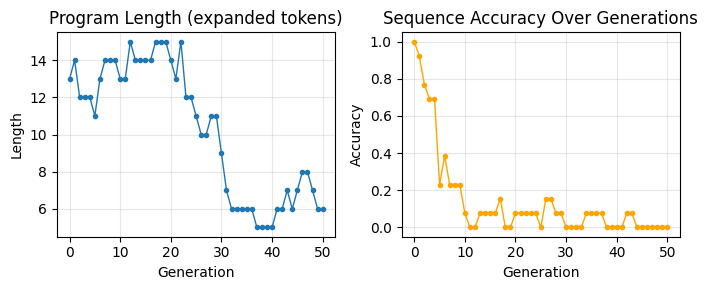

In [34]:
# Plot length and accuracy over generations
fig, axes = plt.subplots(1, 2, figsize=(7, 3))

axes[0].plot(results_df["generation"], results_df["length_expanded"], marker=".", linewidth=1)
axes[0].set_xlabel("Generation")
axes[0].set_ylabel("Length")
axes[0].set_title("Program Length (expanded tokens)")
axes[0].grid(alpha=0.3)

axes[1].plot(results_df["generation"], results_df["accuracy"], marker=".", linewidth=1, color='orange')
axes[1].set_xlabel("Generation")
axes[1].set_ylabel( "Accuracy")
axes[1].set_title("Sequence Accuracy Over Generations")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

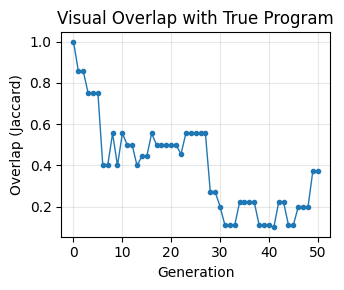

In [35]:
# Visual overlap over generations
plt.figure(figsize=(3.5,3))
plt.plot(results_df["generation"], results_df["visual_overlap"], marker=".", linewidth=1)
plt.xlabel("Generation")
plt.ylabel("Overlap (Jaccard)")
plt.title("Visual Overlap with True Program")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Generation 0 (sequence accuracy = 1.000):
  h l_1 v v r_1 h r_12 h l_4 h l_1 v v


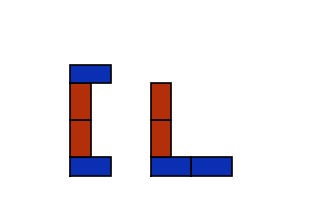


Generation 10 (sequence accuracy = 0.077):
  r_1 v r_6 l_5 v l_5 h l_1 r_12 h l_5 r_4 r_12
  [Rendering skipped: program moves blocks outside valid range]

Generation 50 (sequence accuracy = 0.000):
  l_1 r_12 l_4 l_4 r_4 l_5


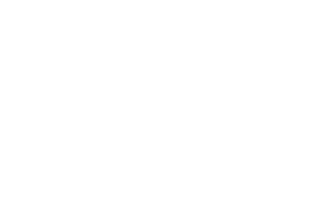

In [36]:
selected_generations = [0, NUM_GENERATIONS // 5, NUM_GENERATIONS]
for g in selected_generations:
    prog_tokens = programs_over_time[g]
    expanded_tokens = expand_program(prog_tokens)
    prog_str_for_render = tokens_to_program(expanded_tokens)
    acc_g = float(results_df.loc[results_df["generation"] == g, "accuracy"].iloc[0])
    print(f"\nGeneration {g} (sequence accuracy = {acc_g:.3f}):")
    print(f"  {prog_str_for_render}")
    try:
        render_program(prog_str_for_render)
    except AssertionError:
        print("  [Rendering skipped: program moves blocks outside valid range]")
    except Exception as e:
        print(f"  [Rendering skipped due to error: {e}]")

 ## Multiple Chains: Complexity-Accuracy Trade-off

 Run many independent chains to explore the complexity-accuracy space.
 This shows the empirical efficiency frontier: the best accuracy achievable at each complexity level.

In [37]:
# Run many independent chains
all_rows = []
for chain_id in range(NUM_CHAINS):
    chain_model = TransmissionChain(dsl=DEFAULT_DSL, random_seed=SEED + chain_id)
    progs = chain_model.run_chain(true_tokens, num_generations=NUM_GENERATIONS)
    for gen_idx, prog_tokens in enumerate(progs):
        length_expanded = expanded_length(prog_tokens)
        acc = sequence_accuracy(true_tokens, prog_tokens)
        all_rows.append({
            "chain": chain_id,
            "generation": gen_idx,
            "length_expanded": length_expanded,
            "accuracy": acc,
        })

multi_df = pd.DataFrame(all_rows)
print(f"Collected {len(multi_df)} data points from {NUM_CHAINS} chains")
print("\nMulti-chain summary (first few rows):")
print(multi_df.head())

Collected 1275 data points from 25 chains

Multi-chain summary (first few rows):
   chain  generation  length_expanded  accuracy
0      0           0               13  1.000000
1      0           1               14  0.923077
2      0           2               12  0.769231
3      0           3               12  0.692308
4      0           4               12  0.692308


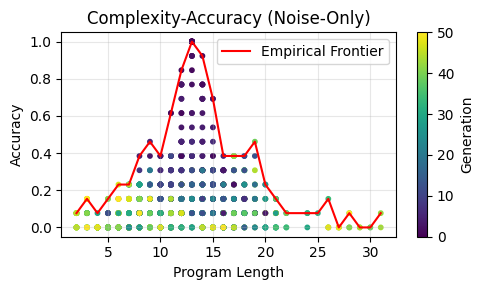

In [52]:
# Complexity-accuracy scatter plot (noise-only)
plt.figure(figsize=(5, 3))
sc = plt.scatter(
    multi_df["length_expanded"],
    multi_df["accuracy"],
    c=multi_df["generation"],
    s=10,
)
plt.colorbar(sc, label="Generation")
plt.xlabel("Program Length")
plt.ylabel("Accuracy")
plt.title("Complexity-Accuracy (Noise-Only)")
plt.grid(alpha=0.3)

# Empirical efficiency frontier
frontier = (
    multi_df.groupby("length_expanded")["accuracy"]
    .max()
    .reset_index()
    .sort_values("length_expanded")
)
plt.plot(
    frontier["length_expanded"],
    frontier["accuracy"],
    color="red",
    label="Empirical Frontier"
)
plt.legend()
plt.tight_layout()
plt.show()

 # 2 Selection-Based Transmission

 Add selection pressure: at each generation, choose the candidate that best balances compression and accuracy.
 This implements a soft Information Bottleneck objective at the token level.

In [39]:
# Run many chains with selection
all_rows_sel = []
for chain_id in range(NUM_CHAINS):
    chain_model = TransmissionChain(dsl=DEFAULT_DSL, random_seed=SEED + 100 + chain_id)
    progs = run_chain_with_selection(
        model=chain_model,
        true_program=true_tokens,
        num_generations=NUM_GENERATIONS,
        lambda_compression=LAMBDA_COMPRESSION,
        num_candidates=NUM_CANDIDATES_TOKEN,
        temperature=SELECTION_TEMPERATURE,
    )
    for gen_idx, prog_tokens in enumerate(progs):
        length_expanded = expanded_length(prog_tokens)
        acc = sequence_accuracy(true_tokens, prog_tokens)
        all_rows_sel.append({
            "chain": chain_id,
            "generation": gen_idx,
            "length_expanded": length_expanded,
            "accuracy": acc,
        })

multi_sel_df = pd.DataFrame(all_rows_sel)
print(f"Collected {len(multi_sel_df)} data points from {NUM_CHAINS} chains (with selection)")
print("\nMulti-chain (selection) summary (first few rows):")
print(multi_sel_df.head())

Collected 1275 data points from 25 chains (with selection)

Multi-chain (selection) summary (first few rows):
   chain  generation  length_expanded  accuracy
0      0           0               13  1.000000
1      0           1               13  1.000000
2      0           2               13  0.923077
3      0           3               11  0.384615
4      0           4               11  0.384615


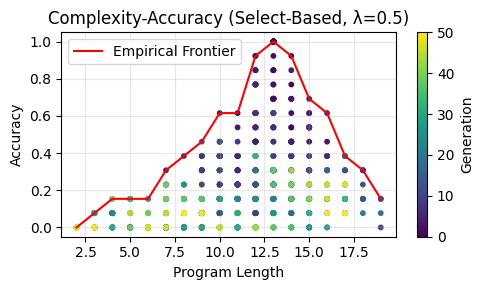

In [55]:
# Complexity-accuracy scatter plot (with selection)
plt.figure(figsize=(5, 3))
sc2 = plt.scatter(
    multi_sel_df["length_expanded"],
    multi_sel_df["accuracy"],
    c=multi_sel_df["generation"],
    s=10,
)
plt.colorbar(sc2, label="Generation")
plt.xlabel("Program Length")
plt.ylabel("Accuracy")
plt.title(f"Complexity-Accuracy (Select-Based, λ={LAMBDA_COMPRESSION})")
plt.grid(alpha=0.3)

# Empirical frontier
frontier_sel = (
    multi_sel_df.groupby("length_expanded")["accuracy"]
    .max()
    .reset_index()
    .sort_values("length_expanded")
)
plt.plot(
    frontier_sel["length_expanded"],
    frontier_sel["accuracy"],
    color="red",
    label="Empirical Frontier"
)
plt.legend()
plt.tight_layout()
plt.show()

 # 3 AST-Based IB with Fragment Learning

 The most sophisticated model:
 - **AST structure**: Programs represented as trees, enabling compositionality
 - **Fragment discovery**: Automatically learn reusable patterns from program history
 - **Explicit IB objective**: Minimize L = C - $\beta$·A where C = complexity, A = accuracy
 - **Structure-preserving reconstruction**: Agents reconstruct programs using learned fragments

 ## Single AST-Based IB Chain

In [41]:
# Run AST-based IB chain
ib_chain = run_chain_ib(
    initial_program=true_tokens,
    true_program=true_tokens,
    num_generations=NUM_GENERATIONS_AST,
    beta=BETA_IB,
    num_candidates=NUM_CANDIDATES_AST,
    fragment_discovery_freq=FRAGMENT_DISCOVERY_FREQ,
    random_seed=SEED,
)

# Collect AST-based metrics
ast_rows = []
for gen_idx, prog_tokens in enumerate(ib_chain):
    ast = tokens_to_ast(prog_tokens)
    true_ast = tokens_to_ast(true_tokens)
    
    length = expanded_length(prog_tokens)
    acc_seq = sequence_accuracy(true_tokens, prog_tokens)
    frag_use = fragment_usage(ast)
    ib_c = ib_complexity(ast)
    ib_a = ib_accuracy(ast, true_ast)
    ib_l = ib_loss(ast, true_ast, beta=BETA_IB)
    
    ast_rows.append({
        "generation": gen_idx,
        "length_expanded": length,
        "accuracy_seq": acc_seq,
        "fragment_usage": frag_use,
        "ib_complexity": ib_c,
        "ib_accuracy": ib_a,
        "ib_loss": ib_l,
    })

ast_df = pd.DataFrame(ast_rows)
print("AST-based IB chain summary (first few rows):")
print(ast_df.head())
print("\nAST-based IB chain final generations:")
print(ast_df.tail())

AST-based IB chain summary (first few rows):
   generation  length_expanded  accuracy_seq  fragment_usage  ib_complexity  \
0           0               13      1.000000             0.0           14.0   
1           1               13      1.000000             0.0           14.0   
2           2               12      0.923077             0.0           13.0   
3           3               11      0.692308             0.0           12.0   
4           4               11      0.692308             0.0           12.0   

   ib_accuracy   ib_loss  
0     1.000000 -1.833333  
1     1.000000 -1.833333  
2     0.962963 -1.788360  
3     0.846154 -1.543956  
4     0.846154 -1.543956  

AST-based IB chain final generations:
    generation  length_expanded  accuracy_seq  fragment_usage  ib_complexity  \
21          21                1      0.076923             0.0            2.0   
22          22                1      0.076923             0.0            2.0   
23          23                1      0.

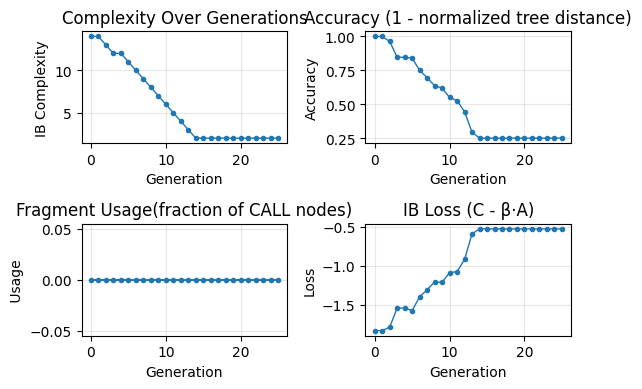

In [60]:
# Plot AST-based chain metrics
fig, axes = plt.subplots(2, 2, figsize=(6, 4))

axes[0, 0].plot(ast_df["generation"], ast_df["ib_complexity"], marker=".", linewidth=1)
axes[0, 0].set_xlabel("Generation")
axes[0, 0].set_ylabel("IB Complexity")
axes[0, 0].set_title("Complexity Over Generations")
axes[0, 0].grid(alpha=0.3)

axes[0, 1].plot(ast_df["generation"], ast_df["ib_accuracy"], marker=".", linewidth=1)
axes[0, 1].set_xlabel("Generation")
axes[0, 1].set_ylabel("Accuracy")
axes[0, 1].set_title("Accuracy (1 - normalized tree distance)")
axes[0, 1].grid(alpha=0.3)

axes[1, 0].plot(ast_df["generation"], ast_df["fragment_usage"], marker=".")
axes[1, 0].set_xlabel("Generation")
axes[1, 0].set_ylabel(" Usage ")
axes[1, 0].set_title("Fragment Usage(fraction of CALL nodes)")
axes[1, 0].grid(alpha=0.3)

axes[1, 1].plot(ast_df["generation"], ast_df["ib_loss"], marker=".", linewidth=1)
axes[1, 1].set_xlabel("Generation")
axes[1, 1].set_ylabel("Loss")
axes[1, 1].set_title("IB Loss (C - β·A)")
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

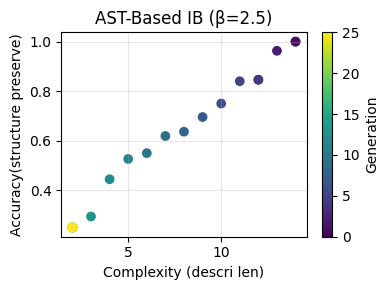

In [64]:
# Complexity-accuracy trajectory for single AST-based IB chain
plt.figure(figsize=(4,3))
sc_ast = plt.scatter(
    ast_df["ib_complexity"],
    ast_df["ib_accuracy"],
    c=ast_df["generation"]
)
plt.colorbar(sc_ast, label="Generation")
plt.xlabel("Complexity (descri len)")
plt.ylabel("Accuracy(structure preserve)")
plt.title(f"AST-Based IB (β={BETA_IB})")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

 ## Multiple AST-Based IB Chains: Fragment Emergence

 Run multiple chains to observe how fragments emerge and are used across different transmission histories.

In [65]:
# Run multiple AST-based IB chains

all_ast_rows = []

for chain_id in range(NUM_AST_CHAINS):
    chain = run_chain_ib(
        initial_program=true_tokens,
        true_program=true_tokens,
        num_generations=NUM_GENERATIONS_AST,
        beta=BETA_IB,
        num_candidates=NUM_CANDIDATES_AST,
        fragment_discovery_freq=FRAGMENT_DISCOVERY_FREQ,
        random_seed=SEED + 200 + chain_id,
    )
    
    for gen_idx, prog_tokens in enumerate(chain):
        ast = tokens_to_ast(prog_tokens)
        true_ast = tokens_to_ast(true_tokens)
        
        all_ast_rows.append({
            "chain": chain_id,
            "generation": gen_idx,
            "ib_complexity": ib_complexity(ast),
            "ib_accuracy": ib_accuracy(ast, true_ast),
            "fragment_usage": fragment_usage(ast),
        })

multi_ast_df = pd.DataFrame(all_ast_rows)
print(f"Collected {len(multi_ast_df)} data points from {NUM_AST_CHAINS} AST-based chains")
print(f"Fragment usage range: [{multi_ast_df['fragment_usage'].min():.3f}, {multi_ast_df['fragment_usage'].max():.3f}]")

Collected 260 data points from 10 AST-based chains
Fragment usage range: [0.000, 0.000]


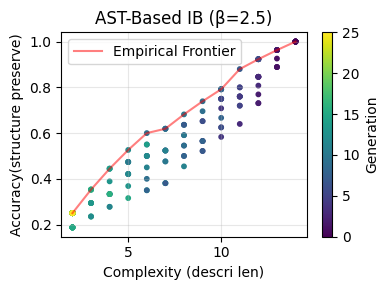

In [68]:
# IB frontier for AST-based chains
plt.figure(figsize=(4, 3))
sc_multi = plt.scatter(
    multi_ast_df["ib_complexity"],
    multi_ast_df["ib_accuracy"],
    c=multi_ast_df["generation"],
    s=10,
)
plt.colorbar(sc_multi, label="Generation")
plt.xlabel("Complexity (descri len)")
plt.ylabel("Accuracy(structure preserve)")
plt.title(f"AST-Based IB (β={BETA_IB})")
plt.grid(alpha=0.3)

# Empirical IB frontier
frontier_ast = (
    multi_ast_df.groupby("ib_complexity")["ib_accuracy"]
    .max()
    .reset_index()
    .sort_values("ib_complexity")
)
plt.plot(
    frontier_ast["ib_complexity"],
    frontier_ast["ib_accuracy"],
    color="red",
    label="Empirical Frontier",
    alpha=0.5
)
plt.legend()
plt.tight_layout()
plt.show()

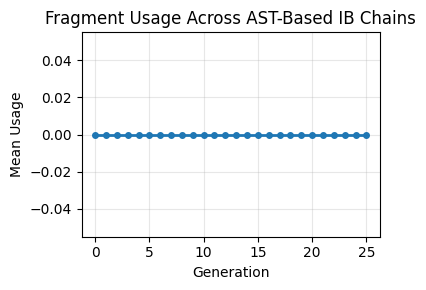

In [69]:
# Fragment usage over generations (averaged across chains)
frag_by_gen = multi_ast_df.groupby("generation")["fragment_usage"].mean().reset_index()

plt.figure(figsize=(4, 3))
plt.plot(frag_by_gen["generation"], frag_by_gen["fragment_usage"], marker=".", linewidth=2, markersize=8)
plt.xlabel("Generation")
plt.ylabel("Mean Usage")
plt.title("Fragment Usage Across AST-Based IB Chains")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()